# Bayesian Trunated Regression Model
This notebook demonstrates how to estimate a Bayesian truncated normal regression model using PyMC. We first import the packages that we will need for generating the data and estiamting the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.stats import norm


We next define a truncation routine that will truncate the observations based on a lower and upper bound.

In [2]:
def truncate(x, y, bounds):
    L, U = bounds
    keep = (y>L) & (y<U)
    keep = keep.squeeze()
    return x[keep], y[keep]

We next define the number of explanatory variables $k$ and the number of observations $n$.

In [3]:
n = 500
k = 2

The next block of code generates the interept and $k$ explanatory variables. The matrix of explanatory variables comes from a standard normal distribution.

In [5]:
intercept = np.ones((n,1))  # Intercept term

explanatory = norm.rvs(0,1, size = (n,k))   # Matrix of explanatory variables N(0,1)

x = np.hstack([intercept, explanatory]) # Place the intecept and explanatory variables in one big matrix

We next set all of the coefficients for the intercept and explanatory variables at 1.

In [7]:
beta = 1.0*np.ones((k+1,1))   # Set all coefficients (including constant) to 1.

We now calcualte the dot product between our $n \times k$ matrix of explanatory variables and our $k \times 1$ vector of coefficients.

In [8]:
temp = x@beta 

We now generate some random noise to add to our regression model.

In [9]:
error = norm.rvs(loc = 0,scale = 1, size = (n,1)) # Error term

Finally, we generate the dependent variable $y$.

In [10]:
y = temp + error

The lower bound for our truncation is -5 and the upper bound is 5. 

In [11]:
L, U = -5, 5


We now truncate the sample.

In [12]:
xt, yt = truncate(x, y, (L, U))

The following are the minimum and maximum values for $yt$, the truncated version of $y$. Note that the lower and upper bounds are approximately equal to $L$ and $U$, respetively.

In [13]:
print(np.min(yt))
print(np.max(yt))

-3.502696680857083
4.89043182899227


We now assign variable names to the columns of the matrix $xt$ and reshape.

In [14]:
xt_1 = xt[:,1].reshape(-1,1)
xt_2 = xt[:,2].reshape(-1,1)

We also have to reshape our $y$ variable.

In [15]:
y = yt[:]

We need to reshape the intercept term to contain the same number of rows as the $X$ variables.

In [16]:
r,c = y.shape
intercept = np.ones(r)

Instantiate a PyMC model.

In [17]:
model_1 = pm.Model()

The next block of code is estimates the model. A few notes worth considering are:

1. The priors are defined for the coefficients (beta) as weakly-informative, with a mean of 0 and a standard deviation of 10.
2. The intercept gets its own prior which is also weakly informative.
3. The prior for the standard deviation sigma is a Half-Normal distribution, since standard deviations can only be positive.
4. The likelihood is a Truncated Normal distribution to take into account the truncation of the dependent variable. The lower and upper bounds are the ones we specified when we generated the data.
5. The sampler uses the NUTS sampler and feel free to experiment with the number of draws and samplers.

In [18]:
with model_1:
    # Prior distributions
    beta = pm.Normal("coef", mu = 0, sigma = 10, size = 2) # Weakly informative prior for coefficients
    sigma = pm.HalfNormal("sigma", sigma = 1) # Weakly informative prior for intercept
    mean = intercept + beta[0]*xt_1 + beta[1]*xt_2 # Formula for our regression model
    
    # Likelihood function
    likelihood = pm.TruncatedNormal("likelihood", mu = mean, sigma = sigma, lower = L, upper = U, observed=y)

    # Sample 
    idata = pm.sample()
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
/home/dolacomb/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


The next code block show the inference data object that is returned.

In [19]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

We can look at the summary statistics and see that the true coeficients, which we all set to 1, are recovered by the sampler. The standard deviation of 1 was also accurately recovered.

In [20]:
az.summary(idata,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef[0],0.997,0.002,0.993,1.001,0.0,0.0,5885.0,3455.0,1.0
coef[1],0.991,0.002,0.987,0.995,0.0,0.0,5988.0,2907.0,1.0
sigma,0.979,0.001,0.977,0.982,0.0,0.0,5956.0,3298.0,1.0


Plotting the posterior marginal distributions for the parameters visually confirms what the summary statistics showed.

/home/dolacomb/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


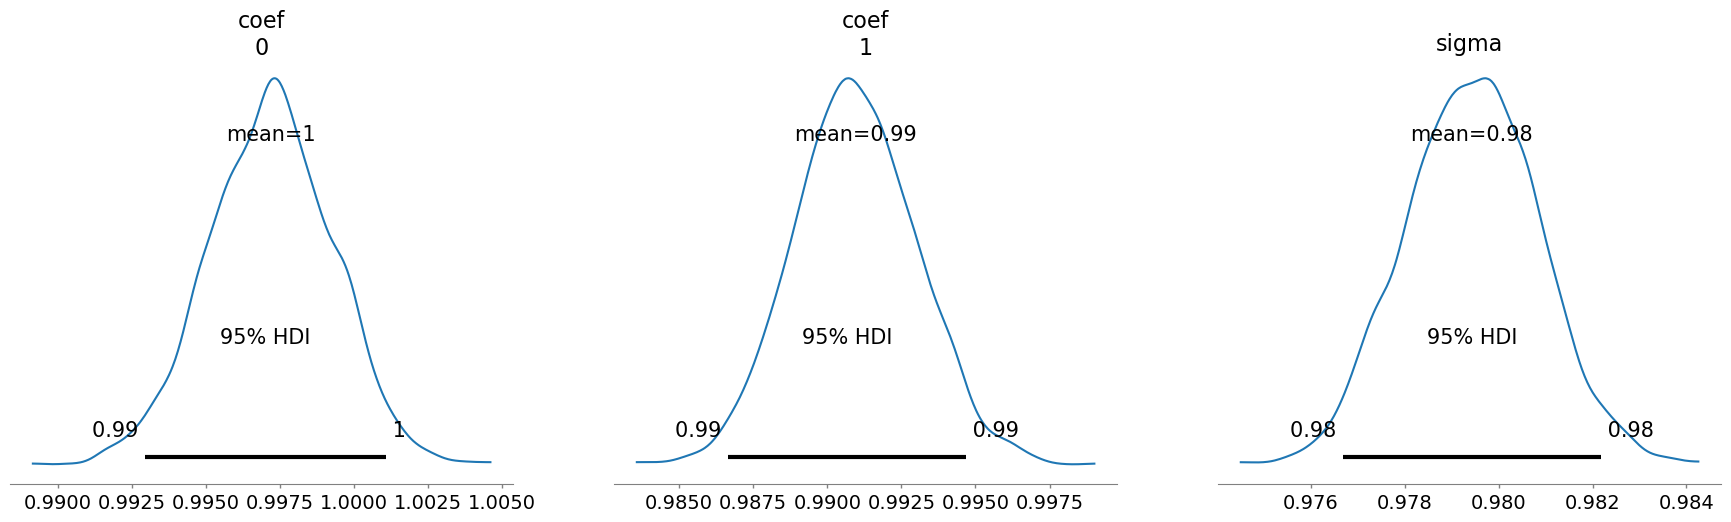

In [21]:
az.plot_posterior(idata,hdi_prob=0.95);

Notebook created by Donald J. Lacombe: donald.lacombe@ttu.edu